In [66]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import timeit
import csv
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
import os
import pandas as pd

In [67]:
# Example set size.
M = 100

# Reset pseudo random generator to a known value so that results are reproducible.
np.random.seed(42)

def target_function(M, x):
    y = 1 + np.sin(2*np.pi*x)
    y = y.reshape(M, 1)
    y_noisy = y + 0.1*np.random.randn(M, 1)
    return y, y_noisy

In [68]:
x = np.linspace(0, 1, M).reshape(M, 1)

y, y_noisy = target_function(M, x)

In [69]:
i = 0
writer = csv.writer(open("./cosine_plus_line", 'w'), delimiter=',')
for row in y_noisy:
    writer.writerow((x[i][0], y_noisy[i][0]))
    i = i + 1                           

In [70]:
df = pd.read_csv('./cosine_plus_line.csv', header=None)

x = df[0].to_numpy()
y_noisy = df[1].to_numpy()           
x = x.reshape(len(x),1)
y_noisy = y_noisy.reshape(len(x),1)

# A.) GRAFICO DE X VERSUS Y MOSTRANDO OS PONTOS RUIDOSOS

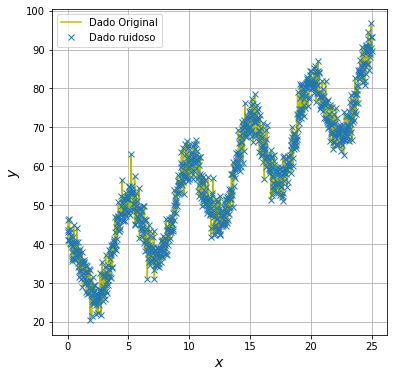

In [71]:
# Plot cost-function surface.
fig = plt.figure(figsize=(6,6))
plt.plot(x, y_noisy, 'y', label='Dado Original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

# Holdout cross-validation (70/30%) 

In [72]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Split the whole set into random training and validation set.
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=42)

print('tamanho conjunto de treinamento:', len(y_train))
print('tamanho conjunto de validação:', len(y_val))

include_bias = True
mean_vec = []
train_vec = []
for d in range(1, 26):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)
    
    train_vec.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))
    
    mean_vec.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))

tamanho conjunto de treinamento: 700
tamanho conjunto de validação: 300
Tempo de execução: 0.1134 [s]


# Erro Quadratico Médio vs. Ordem do Polinômio - Holdout

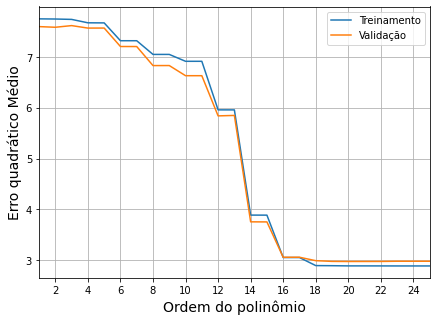

In [73]:
# Plot results.
plt.figure(figsize=(7, 5))
plt.plot(range(1, 26), train_vec, label='Treinamento')
plt.plot(range(1, 26), mean_vec, label='Validação')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 26, 2))
plt.xlim([1, 25])
plt.legend()
plt.grid()
#Show the plot.
plt.show()

# k-fold cross-validation (k=10)

In [74]:
# Instantiate the k-Fold object.
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

mean_vec = []
std_vec = []
for d in range(1, 26):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y_noisy, scoring='neg_mean_squared_error', cv=kfold)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))  

Tempo de execução: 1.7580 [s]


# Erro Quadratico Médio vs. Ordem do Polinômio - k-fold

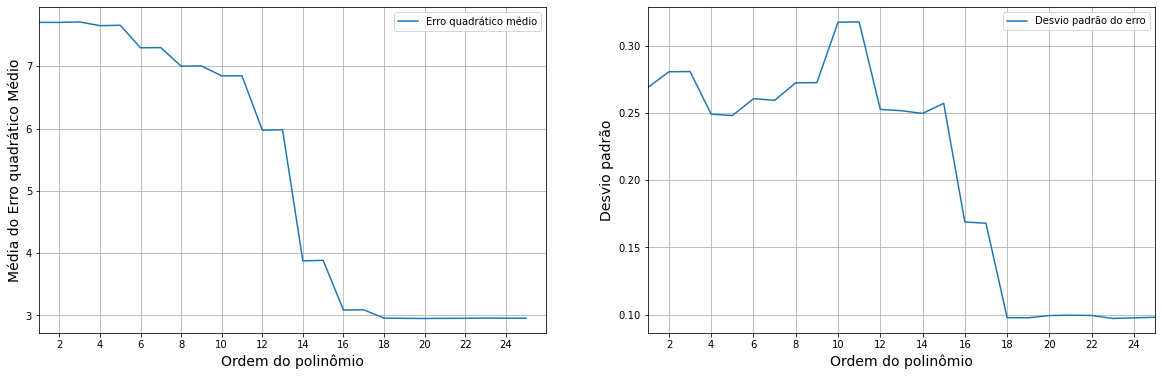

In [75]:
# Plot results.
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 26), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 26, 2))
plt.xlim([1, 26])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 26), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 26, 2))
plt.xlim([1, 25])
plt.legend()
plt.grid() 

# Leave-p-out (p=1)

In [76]:
# Get timestamp of holdout start.
starttime = timeit.default_timer()

# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 26):
    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, x, y_noisy, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
print("Tempo de execução: %1.4f [s]" % (timeit.default_timer() - starttime))  

Tempo de execução: 125.3258 [s]


# Erro Quadratico Médio vs. Ordem do Polinômio - Leave-p-out (p=1)

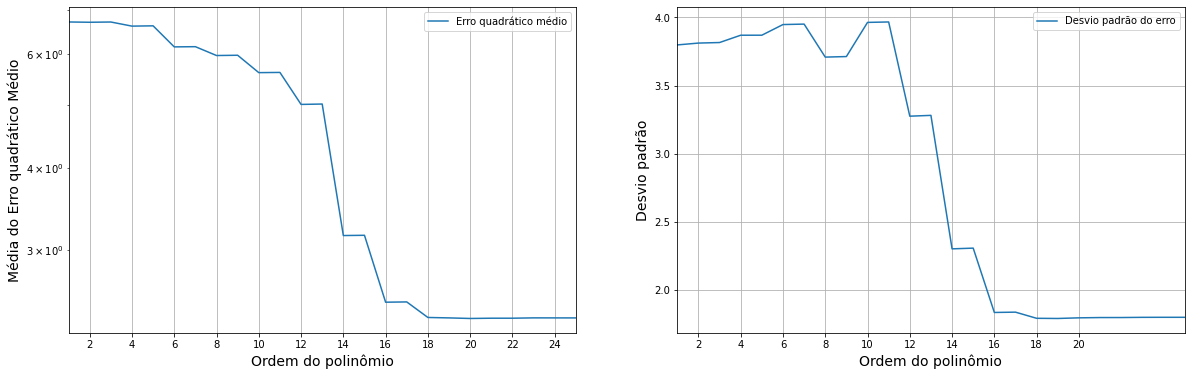

In [77]:
# Plot results.
plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 26), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.yscale('log')
plt.xticks(range(0, 26, 2))
plt.xlim([1, 25])
#plt.ylim([0.78, 0.81])
plt.legend()
plt.grid()

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 26), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 22, 2))
plt.xlim([1, 25])
plt.legend()
plt.grid()


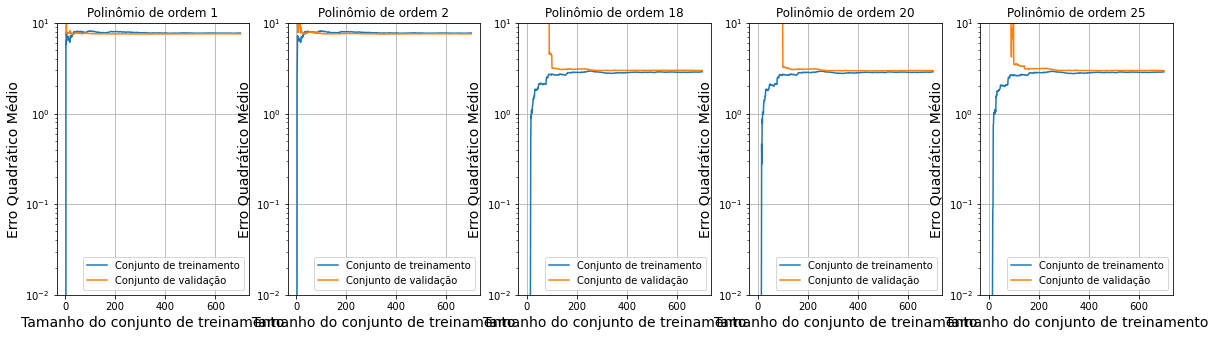

In [80]:
# Polinomial degrees to be tested.
degrees = [1, 2, 18, 20, 25]

plt.figure(figsize=(20, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    # Instantiate a polynomial.
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    # Instantiate a scaler.
    std_scaler = StandardScaler()
    # Instantiate a linear regressor.
    lin_reg = LinearRegression()

    # Create a pipeline of actions.
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    for m in range(1,len(x_train)+1):

        # Perform polynomial regression.
        polynomial_regression.fit(x_train[:m], y_train[:m])

        # Use the trained model for prediction of the training set.
        y_train_predict = polynomial_regression.predict(x_train[:m])

        # Use the trained model for prediction of the validation set.
        y_val_predict = polynomial_regression.predict(x_val)       

        # Calculate MSE for training set.
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        # Calculate MSE for validation set.
        error_validation.append(mean_squared_error(y_val, y_val_predict))       

    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Conjunto de treinamento')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Conjunto de validação')
    plt.yscale('log')
    plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
    plt.ylabel('Erro Quadrático Médio', fontsize=14)
    plt.grid()
    plt.ylim([1e-2, 10])
    plt.title('Polinômio de ordem '+str(degrees[i]))
    plt.legend(loc='best')
    
#Show the plot.
plt.show()

# Resposta:
A melhor ordem de polinômio que aproxima os dados do modelo gerador : Os polinómios de ordem 18 e de ordem 20,mas si aumentarmos o conjunto de treinamento faz com que a diferença entre as duas curvas se torne ainda menor . Mas no entanto seguindo o principio de Occam nos vamos escolher o polinomio de ordem 18 e a hipotese menos complexa que se ajusta bem melhor aos dados que temos.

# Model training


In [81]:
# Best polynomial order
#degree = 3
degree = 18 #apresenta uma melhor ordem em relação ao 3 ele si ajusta melhor aos dados; 

# Instantiate a polynomial with the given degree.
poly_features = PolynomialFeatures(degree=degree, include_bias=include_bias)

# Instantiate a scaler that will standardize the features.
std_scaler = StandardScaler()

# Instantiate a linear regressor.
lin_reg = LinearRegression()

# Create a pipeline of actions.
polynomial_regression = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
    ])

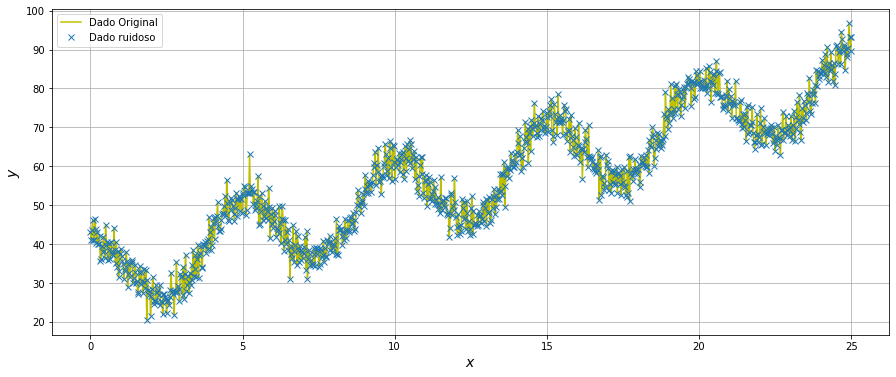

In [86]:
# Plot cost-function surface.
fig = plt.figure(figsize=(15,6))
plt.plot(x, y_noisy, 'y', label='Dado Original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()